In [1]:
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 48.7 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score
import matplotlib.cm as cm

In [3]:
data = pd.read_csv('merged.csv')
data.columns

Index(['Unnamed: 0', 'player_id', 'name_x', 'position_x', 'team_x', 'season_x',
       'conference', 'usage_passing_downs', 'usage_standard_downs',
       'usage_third_down', 'usage_second_down', 'usage_first_down',
       'usage_rush', 'usage_var_pass', 'usage_overall',
       'avg_ppa_passing_downs', 'avg_ppa_standard_downs', 'avg_ppa_third_down',
       'avg_ppa_second_down', 'avg_ppa_first_down', 'avg_ppa_rush',
       'avg_ppa_var_pass', 'avg_ppa_all', 'total_ppa_passing_downs',
       'total_ppa_standard_downs', 'total_ppa_third_down',
       'total_ppa_second_down', 'total_ppa_first_down', 'total_ppa_rush',
       'total_ppa_var_pass', 'total_ppa_all', 'fumbles_FUM', 'fumbles_LOST',
       'fumbles_REC', 'passing_ATT', 'passing_COMPLETIONS', 'passing_INT',
       'passing_PCT', 'passing_TD', 'passing_YDS', 'passing_YPA',
       'receiving_LONG', 'receiving_REC', 'receiving_TD', 'receiving_YDS',
       'receiving_YPR', 'rushing_ATT', 'rushing_LONG', 'rushing_TD',
       'rushing_

In [62]:
# usage
# cols = ['w_av', 'usage_passing_downs', 'usage_standard_downs', 'usage_third_down', 'usage_second_down', 'usage_first_down', 'usage_rush', 'usage_var_pass', 'usage_overall']
# ppa
# cols = ['w_av', 'avg_ppa_passing_downs', 'avg_ppa_standard_downs', 'avg_ppa_third_down', 'avg_ppa_second_down', 'avg_ppa_first_down', 'avg_ppa_rush', 'avg_ppa_var_pass', 'avg_ppa_all']

# QB specific
cols = ['w_av', 'avg_ppa_all', 'passing_COMPLETIONS', 'passing_INT', 'passing_TD', 'passing_YPA', 'rushing_YDS', 'rushing_TD']

cluster_cols = cols[1:]
data[cluster_cols].describe()

,avg_ppa_all,passing_COMPLETIONS,passing_INT,passing_TD,passing_YPA,rushing_YDS,rushing_TD
count,12408.000000,1865.000000,1865.000000,1865.000000,1865.000000,5972.000000,5972.000000
mean,0.426653,70.601768,3.101309,6.165611,7.054639,192.696105,2.001049
std,0.610064,84.577256,3.290772,8.185694,5.181806,284.501685,3.104975
min,-4.300000,0.000000,0.000000,0.000000,-5.000000,-306.000000,0.000000
25%,0.090000,3.666667,0.000000,0.000000,5.000000,13.333333,0.000000
50%,0.349833,29.625000,2.000000,2.000000,6.800000,66.000000,0.700000
75%,0.711000,121.375000,5.333333,9.933333,7.983333,260.208333,2.800000
max,6.900000,475.000000,18.000000,62.000000,59.000000,2587.000000,29.000000


In [63]:
# ── 0. Prep ────────────────────────────────────────────────────────────────────
pos = "QB"
X = data[data['position'] == pos][cols].dropna().drop(columns=['w_av'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

CLUSTER_RANGE = range(2, 9)
LINKAGE_MATRIX = linkage(X_scaled, method='ward')

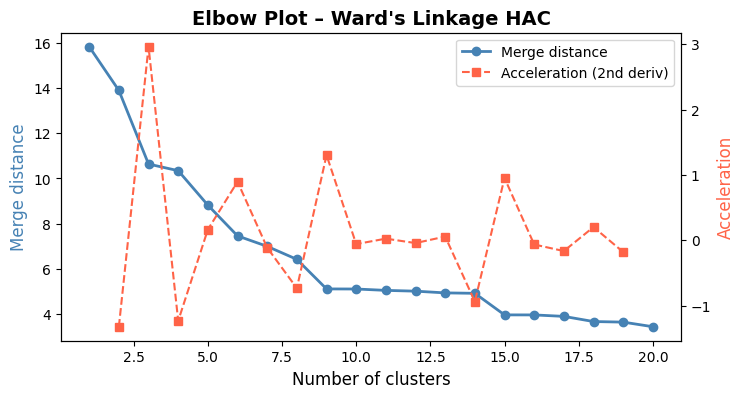

In [64]:
# ── 1. Elbow Plot (last-r merge distances) ─────────────────────────────────────
last      = LINKAGE_MATRIX[-20:, 2]       # last 20 merge distances
rev_last  = last[::-1]
idxs      = np.arange(1, len(rev_last) + 1)
acceleration = np.diff(rev_last, 2)       # 2nd derivative → elbow

fig_elbow, ax = plt.subplots(figsize=(8, 4))
ax.plot(idxs, rev_last, marker='o', linewidth=2, color='steelblue', label='Merge distance')
ax2 = ax.twinx()
ax2.plot(idxs[:-2] + 1, acceleration, marker='s', linewidth=1.5,
         color='tomato', linestyle='--', label='Acceleration (2nd deriv)')
ax.set_xlabel('Number of clusters', fontsize=12)
ax.set_ylabel('Merge distance', fontsize=12, color='steelblue')
ax2.set_ylabel('Acceleration', fontsize=12, color='tomato')
ax.set_title("Elbow Plot – Ward's Linkage HAC", fontsize=14, fontweight='bold')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

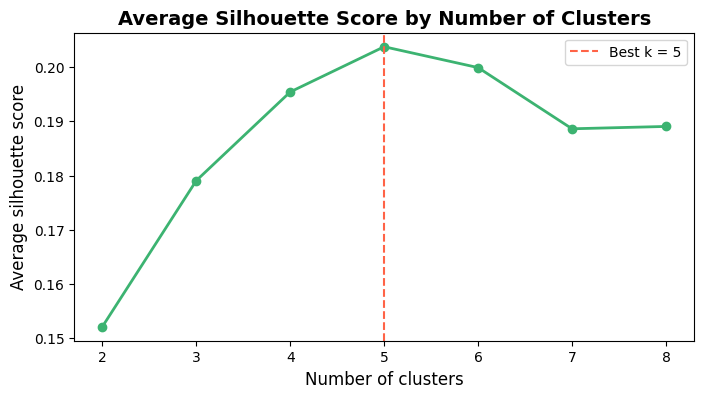

In [65]:
# ── 2. Per-k Metrics ───────────────────────────────────────────────────────────
avg_silhouette, db_scores, all_sil_samples, all_labels = [], [], {}, {}

for k in CLUSTER_RANGE:
    labels = fcluster(LINKAGE_MATRIX, k, criterion='maxclust')
    avg_silhouette.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    all_sil_samples[k] = silhouette_samples(X_scaled, labels)
    all_labels[k] = labels

# ── 3. Average Silhouette Score Plot ──────────────────────────────────────────
fig_sil, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(CLUSTER_RANGE), avg_silhouette, marker='o', linewidth=2, color='mediumseagreen')
best_k = list(CLUSTER_RANGE)[np.argmax(avg_silhouette)]
ax.axvline(best_k, color='tomato', linestyle='--', label=f'Best k = {best_k}')
ax.set_xlabel('Number of clusters', fontsize=12)
ax.set_ylabel('Average silhouette score', fontsize=12)
ax.set_title('Average Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xticks(list(CLUSTER_RANGE))

Text(0.5, 1.01, 'Silhouette Coefficients per Cluster')

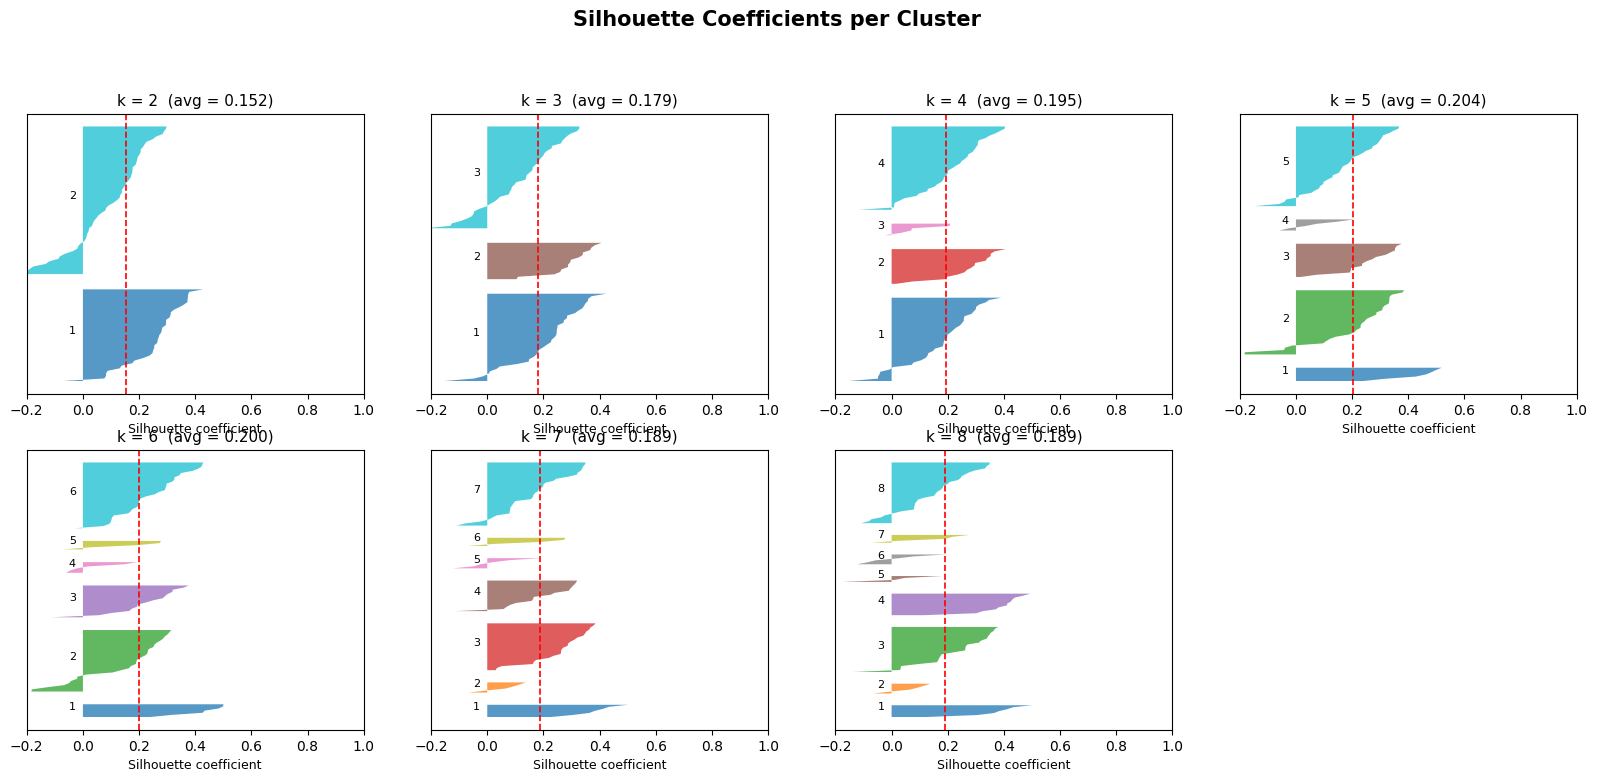

In [66]:
# ── 4. Silhouette Coefficient Plots (one panel per k) ─────────────────────────
n_plots   = len(list(CLUSTER_RANGE))
ncols     = 4
nrows     = (n_plots + ncols - 1) // ncols
fig_coef, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes_flat = axes.flatten()

for idx, k in enumerate(CLUSTER_RANGE):
    ax      = axes_flat[idx]
    samples = all_sil_samples[k]
    labels  = all_labels[k]
    colors  = cm.tab10(np.linspace(0, 1, k))
    y_lower = 10

    for cluster in range(1, k + 1):
        vals = np.sort(samples[labels == cluster])
        size = vals.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                         facecolor=colors[cluster - 1], alpha=0.75)
        ax.text(-0.05, y_lower + size / 2, str(cluster), fontsize=8)
        y_lower = y_upper + 5

    avg = avg_silhouette[idx]
    ax.axvline(avg, color='red', linestyle='--', linewidth=1.2)
    ax.set_title(f'k = {k}  (avg = {avg:.3f})', fontsize=11)
    ax.set_xlabel('Silhouette coefficient', fontsize=9)
    ax.set_xlim([-0.2, 1])
    ax.set_yticks([])

for j in range(idx + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

fig_coef.suptitle('Silhouette Coefficients per Cluster', fontsize=15, fontweight='bold', y=1.01)

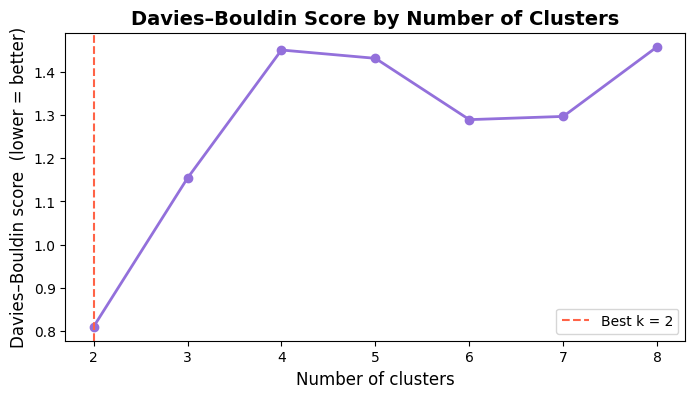

In [55]:
# ── 5. Davies–Bouldin Score Plot ───────────────────────────────────────────────
fig_db, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(CLUSTER_RANGE), db_scores, marker='o', linewidth=2, color='mediumpurple')
best_db_k = list(CLUSTER_RANGE)[np.argmin(db_scores)]
ax.axvline(best_db_k, color='tomato', linestyle='--', label=f'Best k = {best_db_k}')
ax.set_xlabel('Number of clusters', fontsize=12)
ax.set_ylabel('Davies–Bouldin score  (lower = better)', fontsize=12)
ax.set_title('Davies–Bouldin Score by Number of Clusters', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xticks(list(CLUSTER_RANGE))

# Stability Analysis

In [56]:
# ── Config ─────────────────────────────────────────────────────────────────────
N_BOOTSTRAPS  = 100       # number of bootstrap iterations per k
SUBSAMPLE_FRAC = 0.80     # fraction of data used per bootstrap draw
RANDOM_SEED   = 42

rng = np.random.default_rng(RANDOM_SEED)

n_samples = len(X_scaled)

results = {}

In [57]:
# ── Stability Test ─────────────────────────────────────────────────────────────
for k in CLUSTER_RANGE:
    # Reference clustering on full data
    ref_linkage = linkage(X_scaled, method='ward')
    ref_labels  = fcluster(ref_linkage, k, criterion='maxclust')

    ari_scores = []
    for _ in range(N_BOOTSTRAPS):
        # Subsample indices (no replacement keeps cluster structure meaningful)
        idx = rng.choice(n_samples, size=int(n_samples * SUBSAMPLE_FRAC),
                         replace=False)
        X_sub = X_scaled[idx]

        # Refit HAC on subsample
        sub_linkage = linkage(X_sub, method='ward')
        sub_labels  = fcluster(sub_linkage, k, criterion='maxclust')

        # ARI between subsample assignments and reference assignments for same rows
        ari = adjusted_rand_score(ref_labels[idx], sub_labels)
        ari_scores.append(ari)

    results[k] = ari_scores

# ── Summary Table ──────────────────────────────────────────────────────────────
summary = pd.DataFrame({
    'k':         list(CLUSTER_RANGE),
    'mean_ARI':  [round(np.mean(results[k]), 4) for k in CLUSTER_RANGE],
    'std_ARI':   [round(np.std(results[k]),  4) for k in CLUSTER_RANGE],
    'min_ARI':   [round(np.min(results[k]),  4) for k in CLUSTER_RANGE],
    'median_ARI':[round(np.median(results[k]),4) for k in CLUSTER_RANGE],
    'max_ARI':   [round(np.max(results[k]),  4) for k in CLUSTER_RANGE],
})
print(summary.to_string(index=False))

 k  mean_ARI  std_ARI  min_ARI  median_ARI  max_ARI
 2    0.6541   0.2647   0.1585      0.7372   1.0000
 3    0.3952   0.1845   0.2148      0.3143   0.8754
 4    0.5613   0.1466   0.3081      0.5694   0.8693
 5    0.5662   0.1348   0.3335      0.5585   0.8835
 6    0.5714   0.1341   0.3584      0.5641   0.8816
 7    0.5084   0.1366   0.2748      0.5037   0.8877
 8    0.5953   0.1241   0.3511      0.5937   0.8546


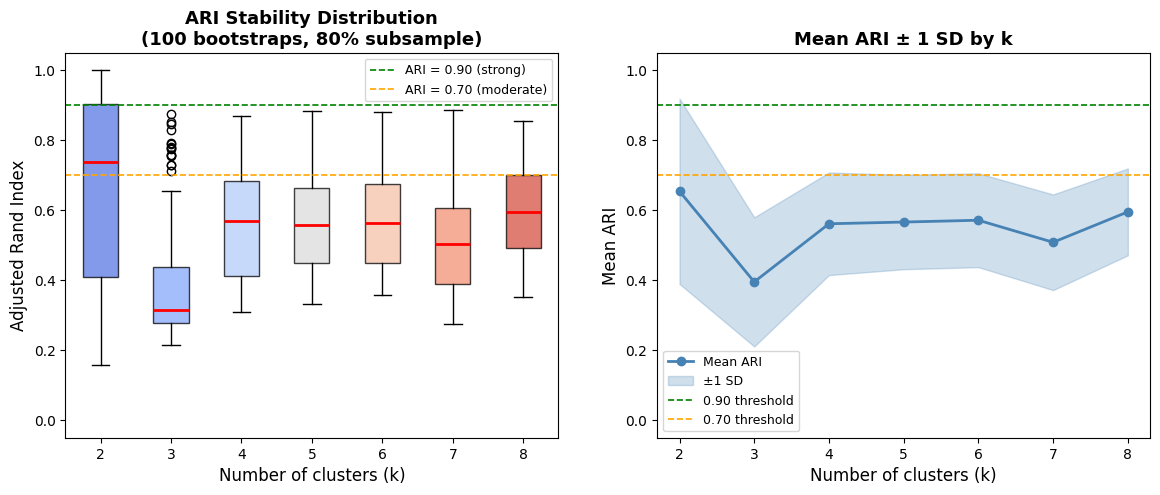

In [58]:
# ── Plot ───────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: boxplot of ARI distributions
box_data = [results[k] for k in CLUSTER_RANGE]
bp = axes[0].boxplot(box_data, patch_artist=True, medianprops=dict(color='red', linewidth=2))
colors = plt.cm.coolwarm(np.linspace(0.1, 0.9, len(list(CLUSTER_RANGE))))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)
axes[0].set_xticklabels(list(CLUSTER_RANGE))
axes[0].set_xlabel('Number of clusters (k)', fontsize=12)
axes[0].set_ylabel('Adjusted Rand Index', fontsize=12)
axes[0].set_title(f'ARI Stability Distribution\n({N_BOOTSTRAPS} bootstraps, {int(SUBSAMPLE_FRAC*100)}% subsample)',
                  fontsize=13, fontweight='bold')
axes[0].axhline(0.9, color='green',  linestyle='--', linewidth=1.2, label='ARI = 0.90 (strong)')
axes[0].axhline(0.7, color='orange', linestyle='--', linewidth=1.2, label='ARI = 0.70 (moderate)')
axes[0].legend(fontsize=9)
axes[0].set_ylim([-0.05, 1.05])

# Right: mean ARI ± 1 SD line chart
means = summary['mean_ARI'].values
stds  = summary['std_ARI'].values
ks    = list(CLUSTER_RANGE)
axes[1].plot(ks, means, marker='o', linewidth=2, color='steelblue', label='Mean ARI')
axes[1].fill_between(ks, means - stds, means + stds, alpha=0.25,
                     color='steelblue', label='±1 SD')
axes[1].axhline(0.9, color='green',  linestyle='--', linewidth=1.2, label='0.90 threshold')
axes[1].axhline(0.7, color='orange', linestyle='--', linewidth=1.2, label='0.70 threshold')
axes[1].set_xlabel('Number of clusters (k)', fontsize=12)
axes[1].set_ylabel('Mean ARI', fontsize=12)
axes[1].set_title('Mean ARI ± 1 SD by k', fontsize=13, fontweight='bold')
axes[1].set_xticks(ks)
axes[1].set_ylim([-0.05, 1.05])
axes[1].legend(fontsize=9)

# Identify Clusters

In [30]:
# ── Config ─────────────────────────────────────────────────────────────────────
K = 3                    # ← set your optimal cluster count here
ALPHA = 0.05             # significance level for statistical tests

Z      = linkage(X_scaled, method='ward')
labels = fcluster(Z, K, criterion='maxclust')

# Attach cluster labels to original (unscaled) data
df_clustered = X.copy()
df_clustered['cluster'] = labels
cluster_ids = sorted(df_clustered['cluster'].unique())

In [45]:
# ── 1. Descriptive Statistics per Cluster per Column ──────────────────────────
stat_rows = []
for col in cluster_cols:
    for cl in cluster_ids:
        vals = df_clustered.loc[df_clustered['cluster'] == cl, col]
        stat_rows.append({
            'column':  col,
            'cluster': cl,
            'n':       len(vals),
            'mean':    vals.mean(),
            'median':  vals.median(),
            'std':     vals.std(),
            'cv_%':    (vals.std() / vals.mean() * 100) if vals.mean() != 0 else np.nan,
            'min':     vals.min(),
            'p25':     vals.quantile(0.25),
            'p75':     vals.quantile(0.75),
            'max':     vals.max(),
            'skew':    vals.skew(),
            'kurt':    vals.kurt(),
        })

desc_stats = pd.DataFrame(stat_rows).round(4)
print("═" * 70)
print("  DESCRIPTIVE STATISTICS BY CLUSTER")
print("═" * 70)
for col in cluster_cols:
    print(f"\n── {col} ──")
    print(desc_stats[desc_stats['column'] == col]
          .drop(columns='column')
          .set_index('cluster')
          .to_string())

══════════════════════════════════════════════════════════════════════
  DESCRIPTIVE STATISTICS BY CLUSTER
══════════════════════════════════════════════════════════════════════

── usage_passing_downs ──
           n    mean  median     std     cv_%     min     p25     p75     max    skew    kurt
cluster                                                                                      
1         99  0.6350  0.6475  0.0973  15.3231  0.3306  0.5840  0.7019  0.8430 -0.6886  0.6718
2        453  0.1023  0.0960  0.0428  41.8416  0.0060  0.0745  0.1277  0.2775  0.7444  0.9854
3        186  0.1548  0.1570  0.0434  28.0089  0.0668  0.1242  0.1827  0.2730  0.1026 -0.4162

── usage_standard_downs ──
           n    mean  median     std     cv_%     min     p25     p75     max    skew    kurt
cluster                                                                                      
1         99  0.4397  0.4491  0.0853  19.4087  0.2433  0.3835  0.4891  0.6630 -0.0097  0.0826
2        453  0

In [46]:
# ── 2. Statistical Tests (Kruskal-Wallis + pairwise Mann-Whitney) ─────────────
from scipy.stats import kruskal, f_oneway, shapiro, mannwhitneyu
from itertools import combinations

print("\n\n═" * 35)
print("  STATISTICAL TESTS")
print("═" * 70)

sig_results = []
for col in cluster_cols:
    groups = [df_clustered.loc[df_clustered['cluster'] == cl, col].values
              for cl in cluster_ids]

    # Normality check (Shapiro on each group; flag if any group is non-normal)
    non_normal = any(
        shapiro(g).pvalue < ALPHA for g in groups if len(g) >= 3
    )

    # Global test: Kruskal-Wallis (non-parametric) or one-way ANOVA
    if non_normal:
        stat, p_global = kruskal(*groups)
        test_name = 'Kruskal-Wallis'
    else:
        stat, p_global = f_oneway(*groups)
        test_name = 'One-way ANOVA'

    sig_flag = '✔ SIGNIFICANT' if p_global < ALPHA else '✘ not significant'
    print(f"\n{col}  [{test_name}]  stat={stat:.4f}  p={p_global:.4f}  {sig_flag}")

    sig_results.append({
        'column': col, 'test': test_name,
        'stat': round(stat, 4), 'p_value': round(p_global, 4),
        'significant': p_global < ALPHA,
    })

    # Pairwise post-hoc (Mann-Whitney U) only if global test is significant
    if p_global < ALPHA:
        print(f"  {'Pair':<15} {'U-stat':>10} {'p-value':>10} {'sig':>6}")
        print(f"  {'-'*45}")
        for (c1, g1), (c2, g2) in combinations(zip(cluster_ids, groups), 2):
            u, p_pair = mannwhitneyu(g1, g2, alternative='two-sided')
            flag = '✔' if p_pair < ALPHA else ''
            print(f"  Cluster {c1} vs {c2}  {u:>10.1f}  {p_pair:>10.4f}  {flag}")

sig_df = pd.DataFrame(sig_results)



═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═

═
  STATISTICAL TESTS
══════════════════════════════════════════════════════════════════════

usage_passing_downs  [Kruskal-Wallis]  stat=370.9493  p=0.0000  ✔ SIGNIFICANT
  Pair                U-stat    p-value    sig
  ---------------------------------------------
  Cluster 1 vs 2     44847.0      0.0000  ✔
  Cluster 1 vs 3     18414.0      0.0000  ✔
  Cluster 2 vs 3     15975.5      0.0000  ✔

usage_standard_downs  [Kruskal-Wallis]  stat=539.4353  p=0.0000  ✔ SIGNIFICANT
  Pair                U-stat    p-value    sig
  ---------------------------------------------
  Cluster 1 vs 2     44847.0      0.0000  ✔
  Cluster 1 vs 3     16936.0      0.0000  ✔
  Cluster 2 vs 3       349.5      0.0000  ✔

usage_third_down  [Kruskal-Wallis]  stat=358.1497  p=0.0000  ✔ SIGNIFICANT
  Pair                U-stat    p-value    sig
  ---------------------------------------------
  Cluster 1 vs 2   

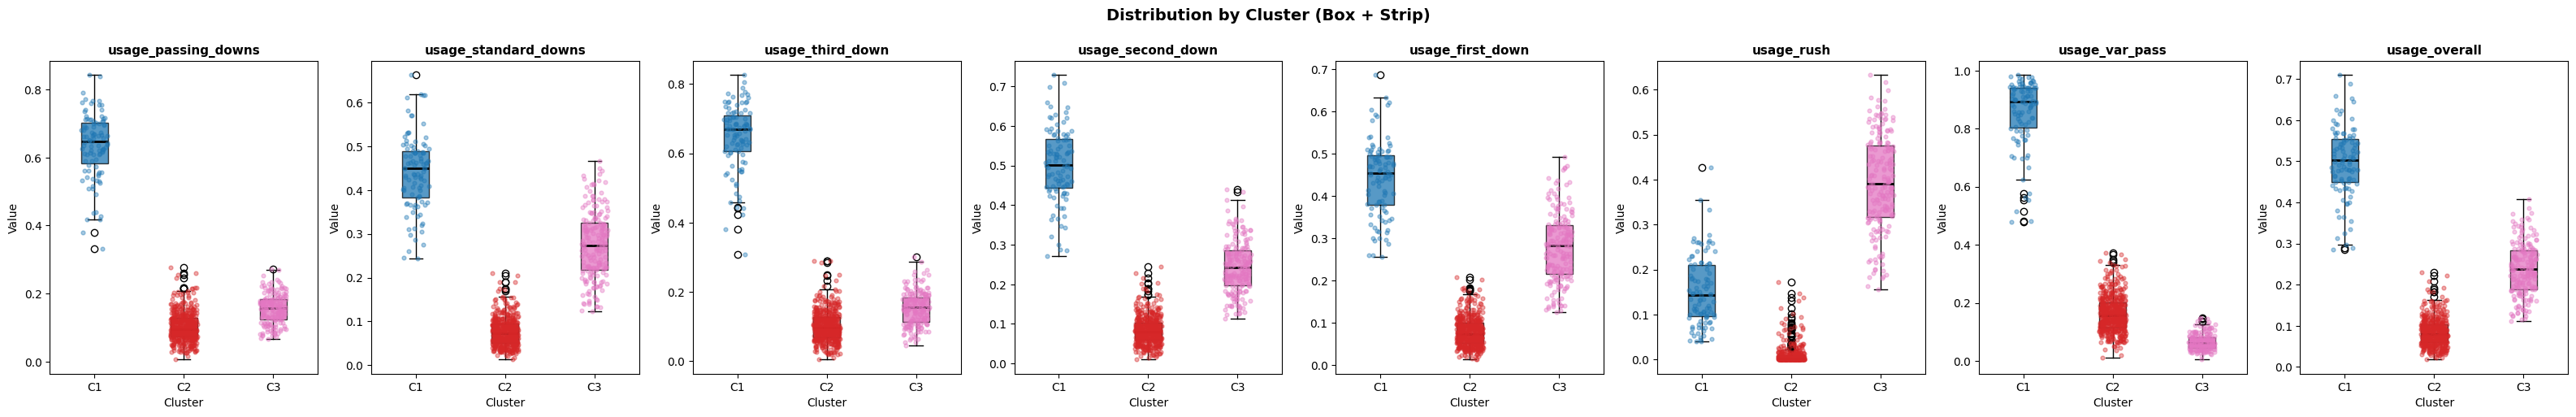

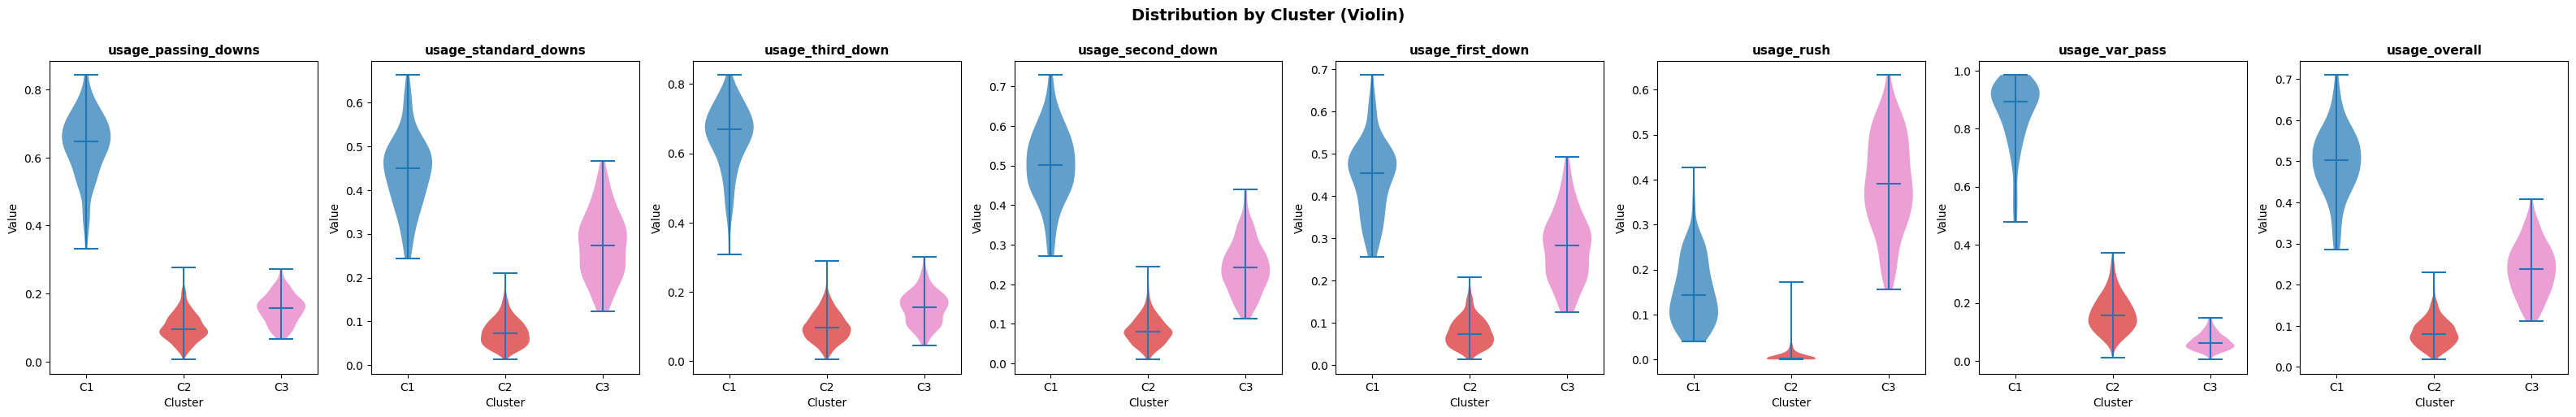

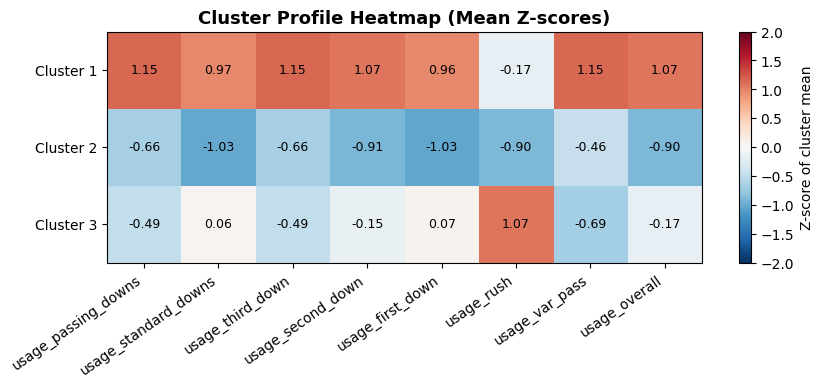

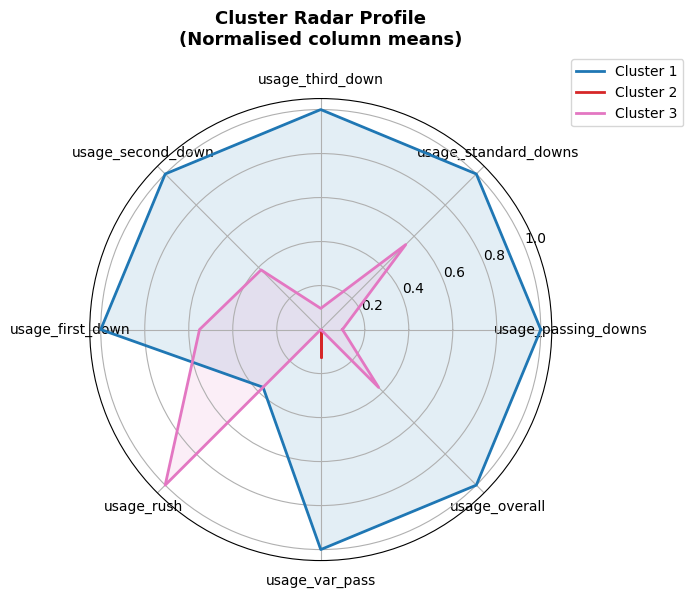

In [47]:
# ── 3. Visualisations ──────────────────────────────────────────────────────────
palette = plt.cm.tab10(np.linspace(0, 0.6, K))
n_cols  = len(cluster_cols)

# 3a. Box + strip plots ─────────────────────────────────────────────────────────
fig_box, axes = plt.subplots(1, n_cols, figsize=(max(5 * n_cols, 10), 5),
                             sharey=False)
if n_cols == 1:
    axes = [axes]

for ax, col in zip(axes, cluster_cols):
    group_data  = [df_clustered.loc[df_clustered['cluster'] == cl, col].values
                   for cl in cluster_ids]
    bp = ax.boxplot(group_data, patch_artist=True,
                    medianprops=dict(color='black', linewidth=2))
    for patch, color in zip(bp['boxes'], palette):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    # Overlay raw points (jittered)
    for i, (cl, vals) in enumerate(zip(cluster_ids, group_data), start=1):
        jitter = np.random.default_rng(42).uniform(-0.15, 0.15, len(vals))
        ax.scatter(np.full(len(vals), i) + jitter, vals,
                   alpha=0.4, s=12, color=palette[i - 1], zorder=3)
    ax.set_xticks(range(1, K + 1))
    ax.set_xticklabels([f'C{cl}' for cl in cluster_ids])
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Value')

fig_box.suptitle('Distribution by Cluster (Box + Strip)', fontsize=14,
                 fontweight='bold', y=1.01)

# 3b. Violin plots ─────────────────────────────────────────────────────────────
fig_vln, axes = plt.subplots(1, n_cols, figsize=(max(5 * n_cols, 10), 5))
if n_cols == 1:
    axes = [axes]

for ax, col in zip(axes, cluster_cols):
    group_data = [df_clustered.loc[df_clustered['cluster'] == cl, col].values
                  for cl in cluster_ids]
    parts = ax.violinplot(group_data, positions=range(1, K + 1),
                          showmedians=True, showextrema=True)
    for i, (body, color) in enumerate(zip(parts['bodies'], palette)):
        body.set_facecolor(color)
        body.set_alpha(0.7)
    ax.set_xticks(range(1, K + 1))
    ax.set_xticklabels([f'C{cl}' for cl in cluster_ids])
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Value')

fig_vln.suptitle('Distribution by Cluster (Violin)', fontsize=14,
                 fontweight='bold', y=1.01)

# 3c. Heatmap: cluster mean Z-scores ───────────────────────────────────────────
mean_z = (df_clustered.groupby('cluster')[cluster_cols]
          .mean()
          .apply(lambda col: (col - col.mean()) / col.std(), axis=0))

fig_heat, ax = plt.subplots(figsize=(max(6, n_cols * 1.2), max(3, K * 0.9)))
im = ax.imshow(mean_z.values, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)
plt.colorbar(im, ax=ax, label='Z-score of cluster mean')
ax.set_xticks(range(n_cols))
ax.set_xticklabels(cluster_cols, rotation=35, ha='right', fontsize=10)
ax.set_yticks(range(K))
ax.set_yticklabels([f'Cluster {cl}' for cl in mean_z.index], fontsize=10)
# Annotate cells
for r in range(K):
    for c in range(n_cols):
        ax.text(c, r, f'{mean_z.values[r, c]:.2f}', ha='center', va='center',
                fontsize=9, color='black')
ax.set_title('Cluster Profile Heatmap (Mean Z-scores)', fontsize=13,
             fontweight='bold')

# 3d. Radar / Spider chart ─────────────────────────────────────────────────────
# Normalise cluster means to [0, 1] per column for radar readability
norm_means = (df_clustered.groupby('cluster')[cluster_cols]
              .mean()
              .apply(lambda c: (c - c.min()) / (c.max() - c.min() + 1e-9),
                     axis=0))

angles  = np.linspace(0, 2 * np.pi, n_cols, endpoint=False).tolist()
angles += angles[:1]   # close the loop

fig_radar, ax = plt.subplots(figsize=(6, 6),
                              subplot_kw=dict(polar=True))
for i, cl in enumerate(norm_means.index):
    vals = norm_means.loc[cl].tolist() + norm_means.loc[cl].tolist()[:1]
    ax.plot(angles, vals, linewidth=2, label=f'Cluster {cl}', color=palette[i])
    ax.fill(angles, vals, alpha=0.12, color=palette[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_cols, size=10)
ax.set_title('Cluster Radar Profile\n(Normalised column means)', fontsize=13,
             fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

In [ ]:
# ── 4. Effect Size: η² per column (proportion of variance explained) ──────────
eta2_rows = []
grand_mean_all = df_clustered[cluster_cols].mean()
for col in cluster_cols:
    grand_mean = df_clustered[col].mean()
    ss_between = sum(
        len(df_clustered[df_clustered['cluster'] == cl]) *
        (df_clustered.loc[df_clustered['cluster'] == cl, col].mean() - grand_mean) ** 2
        for cl in cluster_ids
    )
    ss_total = ((df_clustered[col] - grand_mean) ** 2).sum()
    eta2_rows.append({'column': col, 'eta_squared': round(ss_between / ss_total, 4)})

eta2_df = pd.DataFrame(eta2_rows).sort_values('eta_squared', ascending=False)
print("\n\n═" * 35)
print("  EFFECT SIZE  (η² — proportion of variance explained by cluster)")
print("═" * 70)
print(eta2_df.to_string(index=False))

# Bar chart of η²
fig_eta, ax = plt.subplots(figsize=(max(6, n_cols * 1.1), 4))
bars = ax.bar(eta2_df['column'], eta2_df['eta_squared'],
              color=plt.cm.viridis(np.linspace(0.2, 0.8, len(cluster_cols))),
              edgecolor='white')
ax.axhline(0.14, color='green',  linestyle='--', linewidth=1.2, label='Large effect (η²=0.14)')
ax.axhline(0.06, color='orange', linestyle='--', linewidth=1.2, label='Medium effect (η²=0.06)')
for bar, val in zip(bars, eta2_df['eta_squared']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)
ax.set_ylabel('η² (eta-squared)', fontsize=12)
ax.set_title('Effect Size per Column (Variance Explained by Cluster)',
             fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.legend(fontsize=9)
plt.xticks(rotation=20, ha='right')